<a href="https://colab.research.google.com/github/pabloinsente/CovNet_Human_Drawings/blob/master/code/CovNet_VGG-19_Drawings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature extraction from intermediate layers with VGG19 architecture with weights pre-trained on ImageNet

In [1]:
# Here we use Keras API to process the data by using VGG19 
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [2]:
# Load base model with imagenet pre-trained weights 
base_model = VGG19(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
574717952/574710816 [==============================] - 37s 0us/step


## VGG-19 architecture  

VGG-19 is a 19 layer Convolutional Neural Network  
The **input layer** takes a 224x224x3 image (high, wifth, color channels)  
The **output layer** is a softmax on 1000 classes  
The **feature extraction** part goes from the input layer to the last max pooling layer  
The **classification** part goes from the last max pooling layer to the output layer  

Simonyan, and Zisserman paper:  
https://arxiv.org/pdf/1409.1556.pdf  
Keras reference:  
https://keras.io/applications/#vgg19    
![VGG-19 architecture](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

In [5]:
# Here we can see the progression from layer to layer 
# The output shape column shows how the image gets compressed as 
# it pass through the layers
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# Pick a layer for feature extraction 
# Here we pick the maxpooling layer in block 5
feature_layer = "block5_pool"

# To check other layers
# feature_layer = "block1_pool "
# feature_layer = "block1_conv1 "
 
model = Model(inputs=base_model.input, 
              outputs=base_model.get_layer(feature_layer).output)

In [7]:
# Images are storage in GitHub. By running this we clone the data into Colab
! git clone https://github.com/pabloinsente/CovNet_Human_Drawings
# Run this just once per sesion

Cloning into 'CovNet_Human_Drawings'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 237 (delta 33), reused 221 (delta 28), pack-reused 0
Receiving objects: 100% (237/237), 3.65 MiB | 3.21 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [8]:
# Now repo data is available in Colab local environment
!ls CovNet_Human_Drawings

code  data  README.md


In [0]:
# Drawing data
# You can run this if you want to check the path for a single image
# ! ls CovNet_Human_Drawings/data/humans_drawings/

In [0]:
# Load and reshape the image to be feed into the model
img_path = 'CovNet_Human_Drawings/data/humans_drawings/DAM001_F_DAPedit.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
# Do the feature extraction with block5 pooling layer
block5_pool_features = model.predict(x)

In [11]:
# In block 5, we can check that feature has the same shape that the maxpooling 
# layer in block 5 (above drawing)
# Print tensor shape
print (block5_pool_features.shape)

(1, 7, 7, 512)


In [0]:
# Print extracted feature as a tensor (i.e., feature)
# print(block5_pool_features)

In [24]:
# Print extracted feature flattened as a 1D vector
vgg19_feature_np = np.array(block5_pool_features)
vgg19_feature_np.flatten()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

# Feature extraction from all images

In [25]:
# Get the drwawings filenames from directory 
from os import listdir
from os.path import isfile, join

path = 'CovNet_Human_Drawings/data/humans_drawings/'
filenames = [f for f in listdir(path) if isfile(join(path, f))]
len(filenames) # This should yield 208 

208

In [0]:

# First pick the layer for feature extraction
# A list of the layers' names is obtained by running "base_model.summary()"
feature_layer = "block5_pool" # let's the last max pool as example
model = Model(inputs=base_model.input, 
              outputs=base_model.get_layer(feature_layer).output)

# Let's create a list to save flattened tensors as vectors
vgg19_feature_list = []

# Loop over filenames and append flattened tensor to vector list
for fname in filenames:
  # This part of the loop reshape and preprocess the input images 
  img_path = path + fname
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  # This part of the loop extract the featues and flatten the tensors to vectors
  vgg19_feature = model.predict(x)
  vgg19_feature_np = np.array(vgg19_feature)
  vgg19_feature_list.append(vgg19_feature_np.flatten())
  

In [32]:
# Let's pass the VGG19 feature list to a numpy array
vgg19_feature_list_np = np.array(vgg19_feature_list)
type(vgg19_feature_list_np)
print(vgg19_feature_list_np.shape)

(208, 25088)


# Hierarchical clustering on drawings with vectors extracted from VGG19

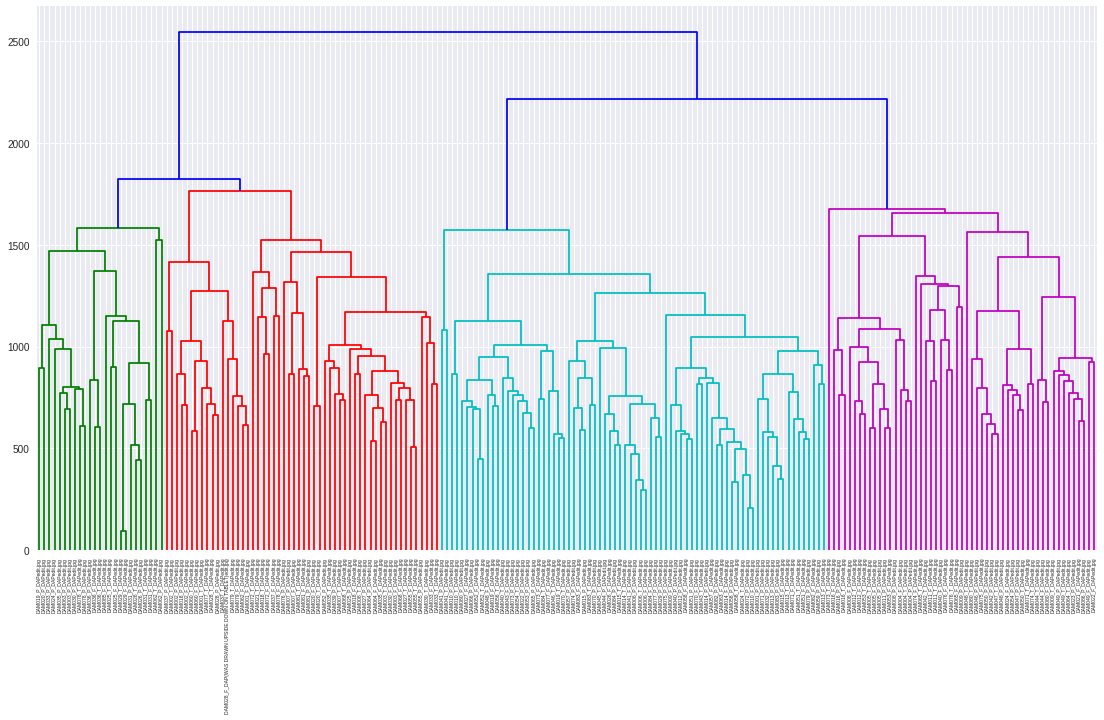

In [46]:
# Let's use scipy to plot a dendogram to do hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

# Let's use the 'ward' method to compute the distance between clusters which 
# minimize the variance between clusters
linked = linkage(vgg19_feature_list_np, 'ward')

# Use filenames as label list
labelList = filenames

# Plot the dendogram as a descendeing tree
plt.figure(figsize=(19, 10))  
dendrogram(linked,  
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [48]:
# Based on the dendogram, it looks like we have 4 clusters
# Let's use sklearn to perform the hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

k = 4
hclustering = AgglomerativeClustering(n_clusters = k, affinity='euclidean', linkage='ward')
hclustering.fit(vgg19_feature_list_np)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')

In [49]:
# Print the cluster to which each image was assigned to
print(hclustering.labels_)  

[3 0 1 0 2 1 0 3 2 1 2 2 0 2 1 1 0 0 2 3 2 1 3 1 3 1 0 0 2 0 2 1 0 2 2 3 2
 1 2 2 3 0 0 2 2 2 1 0 0 1 2 1 1 0 1 0 1 2 2 2 1 2 2 2 2 1 3 0 1 0 2 0 0 2
 0 2 0 0 0 0 1 3 3 1 0 2 1 1 2 1 1 2 1 1 2 3 2 1 1 0 3 2 2 0 2 0 2 3 3 2 2
 0 2 2 0 2 2 2 2 3 2 3 1 2 0 2 0 1 2 2 1 1 0 2 3 2 2 3 0 0 2 0 2 0 2 0 2 0
 1 1 2 1 0 3 1 1 3 1 2 2 2 3 0 3 3 2 0 0 1 1 1 1 1 0 1 2 1 0 1 1 1 0 2 2 2
 1 0 1 3 2 1 0 0 2 0 2 0 2 3 0 2 1 0 2 2 2 2 2]


In [112]:
# Let's create a 2D pandas dataframe to plot the images by cluster later

import pandas as pd

# get filenames as a numpy aray
filenames_np = np.asarray(filenames)

# get cluster labels as a numpr array
clusters_np = hclustering.labels_

# create pandas dataframe stacking numpy arrays by column
drawings_df = pd.DataFrame({'filenames_np':filenames_np, 'clusters_np':clusters_np})

print(type(drawings_df))
print("Shape: ", drawings_df.shape)
print(drawings_df.head())

<class 'pandas.core.frame.DataFrame'>
Shape:  (208, 2)
   clusters_np          filenames_np
0            3  DAM025_T_DAPedit.jpg
1            0  DAM030_F_DAPedit.jpg
2            1  DAM074_F_DAPedit.jpg
3            0  DAM018_T_DAPedit.jpg
4            2  DAM040_T_DAPedit.jpg


In [117]:
# Let's subset the dataframe into 4 samller dataframes by cluster group

# Data frame cluster 0
cluster_0 = drawings_df.loc[drawings_df['clusters_np'] == 0]
print("Lenght cluster 0: ", len(cluster_0))
print(cluster_0.head())

# Data frame cluster 1
cluster_1 = drawings_df.loc[drawings_df['clusters_np'] == 1]
print("Lenght cluster 1: ", len(cluster_1))
print(cluster_1.head())

# Data frame cluster 2
cluster_2 = drawings_df.loc[drawings_df['clusters_np'] == 2]
print("Lenght cluster 2: ", len(cluster_2))
print(cluster_2.head())

# Data frame cluster 3
cluster_3 = drawings_df.loc[drawings_df['clusters_np'] == 3]
print("Lenght cluster 3: ", len(cluster_3))
print(cluster_3.head())

Lenght cluster 0:  54
    clusters_np          filenames_np
1             0  DAM030_F_DAPedit.jpg
3             0  DAM018_T_DAPedit.jpg
6             0  DAM037_F_DAPedit.jpg
12            0  DAM021_T_DAPedit.jpg
16            0  DAM060_T_DAPedit.jpg
Lenght cluster 1:  53
    clusters_np          filenames_np
2             1  DAM074_F_DAPedit.jpg
5             1  DAM005_T_DAPedit.jpg
9             1  DAM004_T_DAPedit.jpg
14            1  DAM076_F_DAPedit.jpg
15            1  DAM065_F_DAPedit.jpg
Lenght cluster 2:  76
    clusters_np          filenames_np
4             2  DAM040_T_DAPedit.jpg
8             2  DAM082_F_DAPedit.jpg
10            2  DAM059_P_DAPedit.jpg
11            2  DAM077_P_DAPedit.jpg
13            2  DAM066_P_DAPedit.jpg
Lenght cluster 3:  25
    clusters_np          filenames_np
0             3  DAM025_T_DAPedit.jpg
7             3  DAM036_F_DAPedit.jpg
19            3  DAM025_F_DAPedit.jpg
22            3  DAM029_T_DAPedit.jpg
24            3  DAM078_T_DAPedit.jpg


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

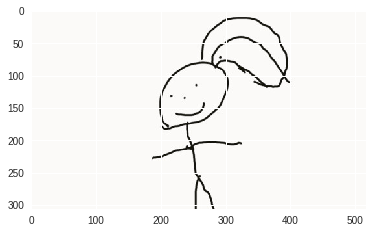

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('CovNet_Human_Drawings/data/humans_drawings/DAM001_F_DAPedit.jpg')
imgplot = plt.imshow(img)
plt.show()